9.10. PROJECT. Определяем количество ботов на сайте

Необходимо:
1. Оценить количество ботов, которые заходят на наш сайт, и их долю от всего трафика.
2. Определить, с каких источников и в какое время суток чаще всего заходят роботы.



In [1]:
#Импортируем библиотеки
import json 
import requests
from pprint import pprint
import pandas as pd

In [2]:
#Сформируем словарь параметров
params = {'metrics': 'ym:s:visits,ym:s:robotPercentage',
          'dimensions': 'ym:s:lastsignTrafficSource,ym:s:hour',  
          'date1': '2020-09-01',  
          'date2': '2020-09-30',     
          'ids': 30177909,
          'accuracy':'full',
          'limit':100000}
token = 'AQAAAAAbjiONAAdTggTIcMCXskYgnDm3QHgUuxk' # вместо слов "ваш_токен" нужно вставить свой токен
headers = {'Authorization': 'OAuth ' + token}
#Создадим переменную и отправим запрос к серверу
response = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params, headers=headers)
print (response.status_code)
#Преобразуем переменную в словарь и изучим ключи
metrika_data = response.json()
print (metrika_data.keys())


200
dict_keys(['query', 'data', 'total_rows', 'total_rows_rounded', 'sampled', 'contains_sensitive_data', 'sample_share', 'sample_size', 'sample_space', 'data_lag', 'totals', 'min', 'max'])


In [3]:
#Смотрим данные
pprint(metrika_data['data'][0:5])
metrika_data['total_rows']

[{'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'},
                 {'id': '16', 'name': '16:00'}],
  'metrics': [251.0, 24.70119522]},
 {'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'},
                 {'id': '15', 'name': '15:00'}],
  'metrics': [240.0, 26.25]},
 {'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'},
                 {'id': '11', 'name': '11:00'}],
  'metrics': [228.0, 25.87719298]},
 {'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'},
                 {'id': '13', 'name': '13:00'}],
  'metrics': [227.0, 2

107

In [4]:
#Создадим датафрейм
metrika_df = pd.DataFrame(metrika_data['data'])
display(metrika_df.head(10))

,dimensions,metrics
0,"[{'icon_id': '2', 'icon_type': 'traffic-source...","[251.0, 24.70119522]"
1,"[{'icon_id': '2', 'icon_type': 'traffic-source...","[240.0, 26.25]"
2,"[{'icon_id': '2', 'icon_type': 'traffic-source...","[228.0, 25.87719298]"
3,"[{'icon_id': '2', 'icon_type': 'traffic-source...","[227.0, 28.1938326]"
4,"[{'icon_id': '2', 'icon_type': 'traffic-source...","[225.0, 24.88888889]"
5,"[{'icon_id': '2', 'icon_type': 'traffic-source...","[225.0, 25.77777778]"
6,"[{'icon_id': '2', 'icon_type': 'traffic-source...","[209.0, 26.31578947]"
7,"[{'icon_id': '2', 'icon_type': 'traffic-source...","[186.0, 19.35483871]"
8,"[{'icon_id': '2', 'icon_type': 'traffic-source...","[166.0, 17.46987952]"
9,"[{'icon_id': '2', 'icon_type': 'traffic-source...","[161.0, 23.60248447]"


In [5]:
#Избавимся от вложенных словарей
def getMetrikaDataInListOfDicts(metrika_data):
    list_of_dicts = []
    dimensions_list = metrika_data['query']['dimensions']
    metrics_list = metrika_data['query']['metrics']
    for data_item in metrika_data['data']:
        d = {}
        for i,dimension in enumerate(data_item['dimensions']):
            d[dimensions_list[i]] = dimension['name']
        for i,metric in enumerate(data_item['metrics']):
            d[metrics_list[i]] = metric
        list_of_dicts.append(d)
    return list_of_dicts

In [6]:
#Преобразуем наши данные и запишем в переменную metrika_list_of_dicts:
metrika_list_of_dicts = getMetrikaDataInListOfDicts(metrika_data)
metrika_df = pd.DataFrame(metrika_list_of_dicts)

In [7]:
#Создадим датафрейм metrika_df
metrika_df = pd.DataFrame(metrika_list_of_dicts)
display(metrika_df.head(3))

,ym:s:lastsignTrafficSource,ym:s:hour,ym:s:visits,ym:s:robotPercentage
0,Search engine traffic,16:00,251.0,24.701195
1,Search engine traffic,15:00,240.0,26.250000
2,Search engine traffic,11:00,228.0,25.877193


In [8]:
#Переименуем столбцы, добавим столбцы с визитами Роботов и Людей.
metrika_df.columns=['Source','Time','Visits','RobotPercentage']
metrika_df['Robots'] = (metrika_df['Visits']*metrika_df['RobotPercentage'])/100
metrika_df['People'] = (metrika_df['Visits']-metrika_df['Robots'])

metrika_df.head(3)


,Source,Time,Visits,RobotPercentage,Robots,People
0,Search engine traffic,16:00,251.0,24.701195,62.0,189.0
1,Search engine traffic,15:00,240.0,26.250000,63.0,177.0
2,Search engine traffic,11:00,228.0,25.877193,59.0,169.0


In [9]:
#Выведем сводную таблицу с данными по источникам, посещениям роботами, людьми и долей роботов от общего трафика.
pivot_df=metrika_df.pivot_table(
    index='Source',
    values=['Visits','People','Robots'],
    aggfunc='sum',
    fill_value=0)
pivot_df['RobotShare%']=round((pivot_df['Robots']/pivot_df['People'])*100, 2)
display(pivot_df)

,People,Robots,Visits,RobotShare%
Source,,,,
Cached page traffic,5,1,6,20.00
Direct traffic,580,177,757,30.52
Internal traffic,7,3,10,42.86
Link traffic,95,31,126,32.63
Recommendation system traffic,2,0,2,0.00
Search engine traffic,2595,739,3334,28.48
Social network traffic,69,11,80,15.94


In [10]:
#Выведем сводную таблицу с с посещениями роботами, людьми и долей роботов от общего трафика по часам. 
pivot_df1=metrika_df.pivot_table(
    index='Time',
    values=['Visits','People','Robots'],
    aggfunc='sum',
    fill_value=0)
pivot_df1['RobotShare%']=round((pivot_df1['Robots']/pivot_df1['Visits'])*100, 2)
display(pivot_df1)

,People,Robots,Visits,RobotShare%
Time,,,,
00:00,96,19,115,16.52
01:00,61,13,74,17.57
02:00,49,7,56,12.50
03:00,32,6,38,15.79
04:00,27,6,33,18.18
05:00,38,4,42,9.52
06:00,45,8,53,15.09
07:00,73,12,85,14.12
08:00,123,36,159,22.64


<AxesSubplot:xlabel='Time'>

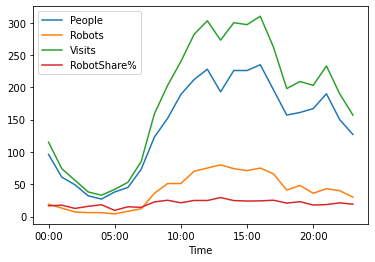

In [11]:
#Построим график для наглядного сравнения
pivot_df1.plot()

In [12]:
#Сделаем датафрейм с общими значениями
a=(metrika_df.drop(['Source','Time','RobotPercentage'], axis = 1)).sum()
df=pd.DataFrame(a).T
df['RobotShare%']=round((df['Robots']/df['Visits'])*100, 2)
df


,Visits,Robots,People,RobotShare%
0,4315.0,962.0,3353.0,22.29


    Вывод по вопросу №1:
    Количество ботов заходящих на сайт 962, что составляет 22.29% от общего количества визитов.

In [13]:
#Определим с каких источников и в какое время чаще всего заходят боты
pivot_df2=metrika_df.loc[metrika_df['Robots']>10].pivot_table(
    index='Time',
    values='Robots',
    columns=['Source'],
    aggfunc='sum',
    fill_value=0)
display(pivot_df2)


Source,Direct traffic,Search engine traffic
Time,,
00:00,0,17
08:00,0,29
09:00,12,36
10:00,0,36
11:00,0,59
12:00,15,56
13:00,13,64
14:00,14,58
15:00,0,63


<AxesSubplot:xlabel='Time'>

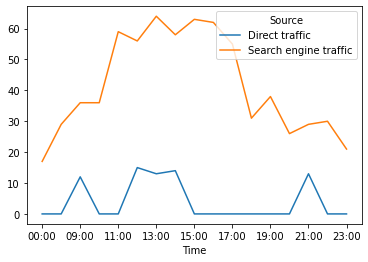

In [14]:
#построим график
pivot_df2.plot()

    Вывод по вопросу №2:
    На основании данных можно выделить два источника:
    1. Direct traffic	
    2. Search engine traffic
    Отмечу, что с источника Search engine traffic активность ботов не прекращается всё время, самый пик приходится на период с 11:00-17:00.
    У источника Direct traffic определена активность в 9:00, в период с 12:00-14:00 и в 21:00.